# 第12章: 完全なMLパイプライン

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] Pipeline を使って前処理とモデルを統合できる
- [ ] モデルを保存・読み込みできる
- [ ] 本番環境用の予測関数を作成できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ 全ての基本ノートブック（01-11）
- ✅ Pipeline概念

⏱️ **推定学習時間**: 60-90分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 統合

---


## 💡 イントロダクション：なぜこれを学ぶのか？

### モチベーション

[この章の重要性を説明]

### 実世界での応用

[具体的な応用例]

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: Data Loading and Exploration

In [2]:
# ============================================================
# [コードの説明]
# ============================================================

# Generate synthetic dataset
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=12,
    n_redundant=4,
    n_classes=2,
    weights=[0.7, 0.3],
    random_state=42
)

# Create DataFrame
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nTarget distribution:\n{df['target'].value_counts()}")
print(f"\nFeature statistics:\n{df.describe().T.head()}") 

Dataset Overview:
Shape: (2000, 21)

Target distribution:
target
0    1396
1     604
Name: count, dtype: int64

Feature statistics:
            count      mean       std        min       25%       50%  \
feature_0  2000.0 -0.019661  1.003055  -3.532818 -0.670322  0.004671   
feature_1  2000.0 -0.765036  2.114654  -8.750474 -2.238578 -0.811866   
feature_2  2000.0 -0.773395  2.183389  -8.530007 -2.240547 -0.785250   
feature_3  2000.0  0.081377  2.161549  -6.664266 -1.430194 -0.169911   
feature_4  2000.0 -0.475659  4.212922 -17.347968 -3.434479 -0.563721   

                75%        max  
feature_0  0.669595   3.691625  
feature_1  0.573074   7.020183  
feature_2  0.683122   6.820509  
feature_3  1.476804   8.946534  
feature_4  2.377179  13.433486  


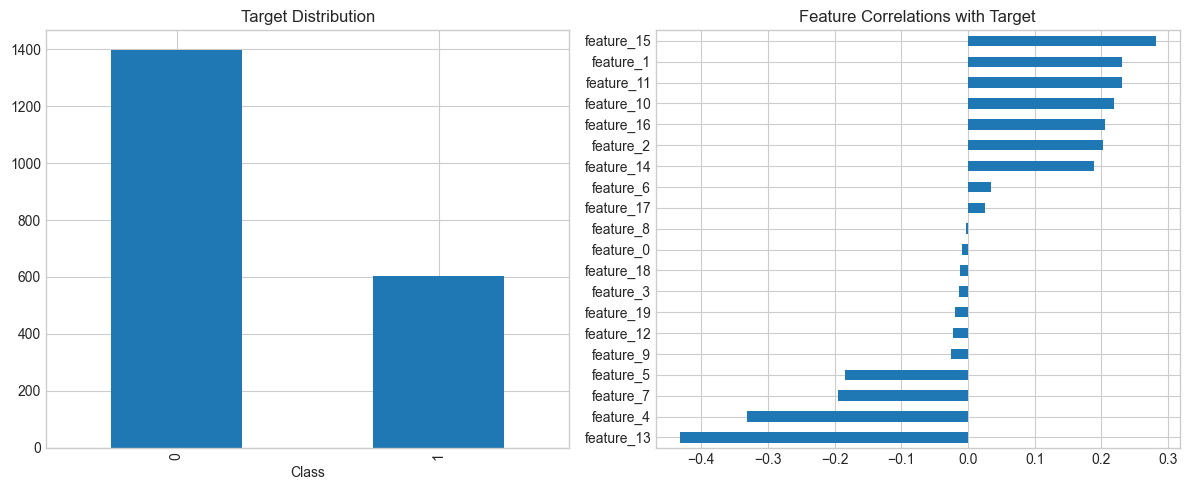

In [3]:
# Quick visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Target distribution
df['target'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Target Distribution')
axes[0].set_xlabel('Class')

# Feature correlations with target
correlations = df.corr()['target'].drop('target').sort_values()
correlations.plot(kind='barh', ax=axes[1])
axes[1].set_title('Feature Correlations with Target')

plt.tight_layout()
plt.show()

## Part 2: Data Splitting

In [4]:
# ============================================================
# [コードの説明]
# ============================================================

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining class distribution:\n{y_train.value_counts()}")

Training set: 1600 samples
Test set: 400 samples

Training class distribution:
target
0    1117
1     483
Name: count, dtype: int64


## Part 3: Build Pipeline

In [5]:
# ============================================================
# [コードの説明]
# ============================================================

# Create pipeline with preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        alpha=0.001,
        max_iter=500,
        early_stopping=True,
        random_state=42
    ))
])

print("Pipeline steps:")
for name, step in pipeline.steps:
    print(f"  {name}: {step.__class__.__name__}")

Pipeline steps:
  scaler: StandardScaler
  classifier: MLPClassifier


In [6]:
# ============================================================
# [コードの説明]
# ============================================================

# Cross-validation on pipeline
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

CV Accuracy: 0.9331 (+/- 0.0133)


## Part 4: Hyperparameter Tuning with Pipeline

In [7]:
# ============================================================
# [コードの説明]
# ============================================================

# Define parameter grid (note: prefix with step name)
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__learning_rate_init': [0.001, 0.01]
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")
print(f"\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best CV Score: 0.9437

Best Parameters:
  classifier__alpha: 0.0001
  classifier__hidden_layer_sizes: (100, 50)
  classifier__learning_rate_init: 0.01


## Part 5: Final Evaluation

In [8]:
# Get best model
best_pipeline = grid_search.best_estimator_

# Predictions
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

# Metrics
print("Final Model Evaluation:")
print("="*50)
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Final Model Evaluation:

Test Accuracy: 0.9675
ROC-AUC: 0.9917

Classification Report:

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       279
           1       1.00      0.89      0.94       121

    accuracy                           0.97       400
   macro avg       0.98      0.95      0.96       400
weighted avg       0.97      0.97      0.97       400



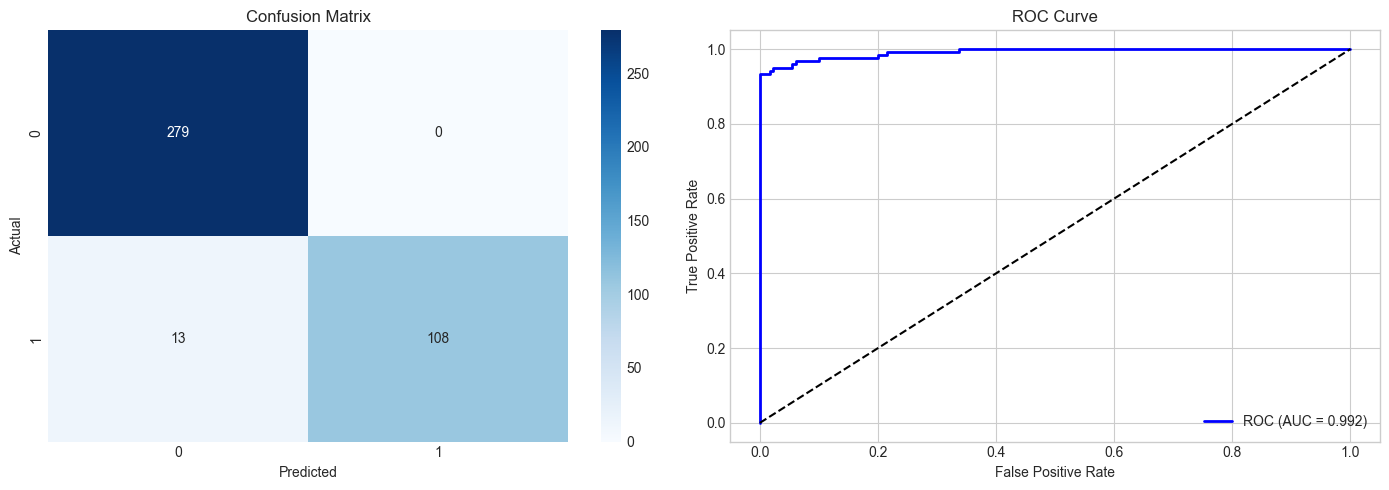

In [9]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)
axes[1].plot(fpr, tpr, 'b-', lw=2, label=f'ROC (AUC = {auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

plt.tight_layout()
plt.show()

## Part 6: Save and Load Model

In [10]:
# ============================================================
# [コードの説明]
# ============================================================

# Save the complete pipeline
model_filename = 'best_mlp_pipeline.joblib'
joblib.dump(best_pipeline, model_filename)
print(f"Model saved to: {model_filename}")

# Load and verify
loaded_pipeline = joblib.load(model_filename)
loaded_score = loaded_pipeline.score(X_test, y_test)
print(f"Loaded model test score: {loaded_score:.4f}")

Model saved to: best_mlp_pipeline.joblib
Loaded model test score: 0.9675


## Part 7: Production-Ready Prediction Function

In [11]:
def predict_new_data(model_path, new_data):
    """
    Load model and make predictions on new data.
    
    Parameters:
    -----------
    model_path : str
        Path to saved model
    new_data : array-like
        New samples to predict
        
    Returns:
    --------
    predictions : array
        Class predictions
    probabilities : array
        Class probabilities
    """
    # Load model
    model = joblib.load(model_path)
    
    # Convert to DataFrame if needed
    if not isinstance(new_data, pd.DataFrame):
        new_data = pd.DataFrame(new_data, columns=feature_names)
    
    # Predict
    predictions = model.predict(new_data)
    probabilities = model.predict_proba(new_data)
    
    return predictions, probabilities

# Test with sample data
sample = X_test.iloc[:5]
preds, probs = predict_new_data(model_filename, sample)

print("Sample Predictions:")
for i, (pred, prob) in enumerate(zip(preds, probs)):
    print(f"  Sample {i}: Class {pred}, Prob: {prob}")

Sample Predictions:
  Sample 0: Class 0, Prob: [0.99701035 0.00298965]
  Sample 1: Class 1, Prob: [8.05028718e-05 9.99919497e-01]
  Sample 2: Class 0, Prob: [9.99981169e-01 1.88312450e-05]
  Sample 3: Class 1, Prob: [1.67147548e-04 9.99832852e-01]
  Sample 4: Class 0, Prob: [9.99999982e-01 1.82583042e-08]


## Part 8: Complete Workflow Summary

In [12]:
# ============================================================
# [コードの説明]
# ============================================================

print("Complete ML Pipeline Workflow:")
print("="*60)
print()
print("1. DATA LOADING")
print("   • Load data from source")
print("   • Initial exploration and visualization")
print("   • Check for missing values and outliers")
print()
print("2. DATA SPLITTING")
print("   • Train/test split (80/20 typical)")
print("   • Stratify for imbalanced classes")
print("   • Keep test set untouched until final evaluation")
print()
print("3. PIPELINE CONSTRUCTION")
print("   • Preprocessing (scaling, encoding)")
print("   • Feature selection (optional)")
print("   • Model")
print()
print("4. HYPERPARAMETER TUNING")
print("   • GridSearchCV or RandomizedSearchCV")
print("   • Cross-validation")
print("   • Select best parameters")
print()
print("5. FINAL EVALUATION")
print("   • Test set performance")
print("   • Multiple metrics")
print("   • Confusion matrix and ROC curve")
print()
print("6. MODEL PERSISTENCE")
print("   • Save with joblib")
print("   • Version control model artifacts")
print("   • Document model parameters")

Complete ML Pipeline Workflow:

1. DATA LOADING
   • Load data from source
   • Initial exploration and visualization
   • Check for missing values and outliers

2. DATA SPLITTING
   • Train/test split (80/20 typical)
   • Stratify for imbalanced classes
   • Keep test set untouched until final evaluation

3. PIPELINE CONSTRUCTION
   • Preprocessing (scaling, encoding)
   • Feature selection (optional)
   • Model

4. HYPERPARAMETER TUNING
   • GridSearchCV or RandomizedSearchCV
   • Cross-validation
   • Select best parameters

5. FINAL EVALUATION
   • Test set performance
   • Multiple metrics
   • Confusion matrix and ROC curve

6. MODEL PERSISTENCE
   • Save with joblib
   • Version control model artifacts
   • Document model parameters


## Summary

Congratulations! You've completed the ML Learning curriculum.

### What You've Learned

**Foundations (Notebooks 1-3)**
- Data simulation and generation
- Preprocessing and feature engineering
- Model evaluation metrics

**Classical Models (Notebooks 4-6)**
- Linear models and regularization
- Tree and ensemble methods
- SVM and kernel methods

**Neural Networks (Notebooks 7-9)**
- MLP fundamentals
- Hyperparameter space exploration
- Waveform prediction with regression

**Advanced Topics (Notebooks 10-12)**
- Automated hyperparameter tuning
- Model comparison and selection
- Complete ML pipelines

### Next Steps
1. Apply these techniques to real datasets
2. Explore deep learning (TensorFlow/PyTorch)
3. Learn specialized domains (NLP, Computer Vision)
4. Study MLOps and model deployment

### Resources
- scikit-learn documentation: https://scikit-learn.org
- Kaggle competitions for practice
- UCI ML Repository for datasets

Happy Learning!

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

実践プロジェクトに挑戦！

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
